In [1]:
import sys, os
sys.path.append('../')
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from inversion_attacks import GradientInversion_Attack
from inversion_attacks.utils.utils import NumpyDataset, ConservativeStrategy, plot, multi_plot
from inversion_attacks.utils.models import LeNet, ConvNet
from inversion_attacks.utils.evaluation_metrics import psnr
from inversion_attacks.utils.consts import *
from inversion_attacks.utils.dataloader import construct_dataloaders

import numpy as np
from PIL import Image

from IQA_pytorch import SSIM 
import lpips 
import csv 


In [2]:
torch.manual_seed(5)
num_classes = 1000
channel = 3
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
setup = dict(device=device, dtype=torch.float)  
print(setup)
defs = ConservativeStrategy()
batch_size = 8

{'device': device(type='cuda', index=0), 'dtype': torch.float32}


In [3]:
# dm = torch.as_tensor(imagenet_mean, **setup)[:, None, None] 
# ds = torch.as_tensor(imagenet_std, **setup)[:, None, None] 

dm = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None]
ds = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None] 


# torch.manual_seed(5)
# torch.cuda.manual_seed(5)
# np.random.seed(5)
loss_fn, dataloader, validloader =  construct_dataloaders('ImageNet', defs,data_path='/data2/imagenet2012')

tensor([337, 219, 862, 403,  11, 160, 700, 438])


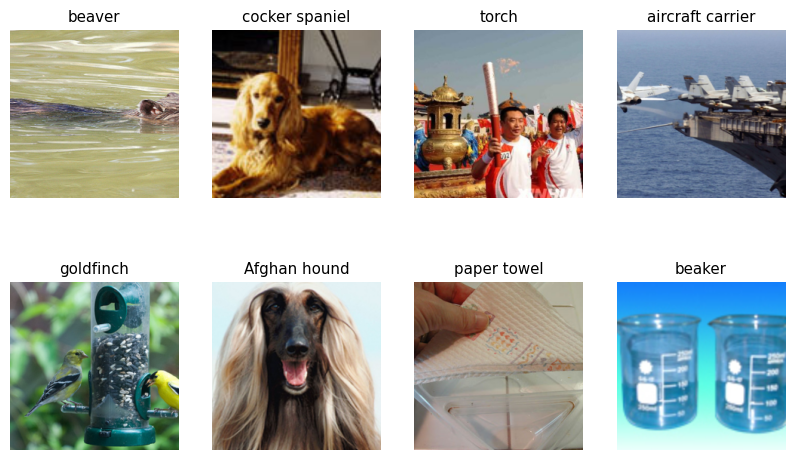

In [4]:
for i, (ground_truth,labels) in enumerate(dataloader):
    print(labels)
    ground_truth = ground_truth.to(device)
    labels = labels.to(device)
    multi_plot(ground_truth,ds,dm,labels,dataloader.dataset.classes)
    break

In [5]:
shape_img=tuple(ground_truth[0].shape)

print(shape_img)
print("seed label: ", labels, labels.shape)

(3, 224, 224)
seed label:  tensor([337, 219, 862, 403,  11, 160, 700, 438], device='cuda:0') torch.Size([8])


In [6]:
# net = getattr(torchvision.models, 'resnet50')()
# net = getattr(torchvision.models, 'resnet18')()
net = LeNet(channel=channel, hideen=37632, num_classes=num_classes)
# net = ConvNet(num_classes=num_classes)
net = net.to(device)

In [7]:
bn_reg_layers = list()
for layer in net.modules():
    if isinstance(layer,torch.nn.modules.batchnorm.BatchNorm2d): 
        bn_reg_layers.append(layer)
print(len(bn_reg_layers))

3


torch.Size([8, 3, 224, 224])


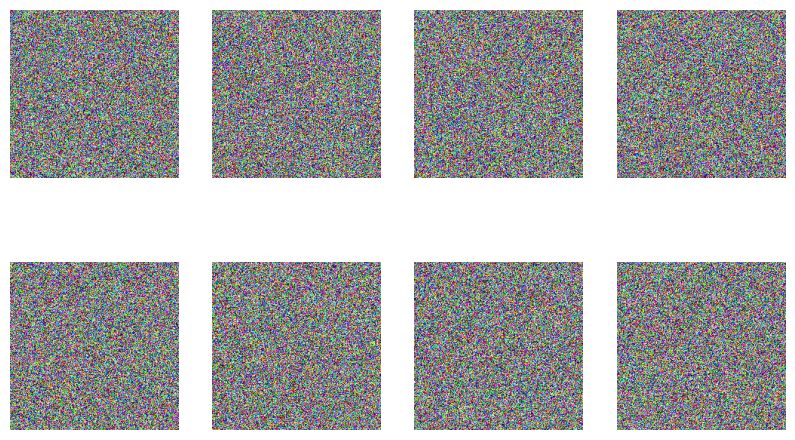

In [8]:
# x_init = torch.randn(ground_truth.shape,requires_grad=True,).to(**setup)
x_init = torch.randn((batch_size,) + (shape_img)).to(**setup)
print(x_init.shape)
multi_plot(x_init,ds,dm)
x_init.requires_grad = True

In [9]:
net.eval()
net.zero_grad()
ground_truth.requires_grad = True

In [10]:
pred = net(ground_truth)
loss, _, _ = loss_fn(pred, labels)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]
print(len(received_gradients))

14


In [11]:
# dlg_attacker_1 = GradientInversion_Attack(
#         net, 
#         shape_img, 
#         mean_std=(dm,ds), 
#         lr=1.0,#1.0, 
#         log_interval=100, 
#         num_iteration=20,#3000, 
#         distancename="l2",
#         device=device,early_stopping=1000,
#         lr_decay=True,
#         optimize_label=True
#     )

# gs_attacker_1 = GradientInversion_Attack(
#             net,
#             shape_img,
#             mean_std=(dm,ds),
#             lr=0.001, #lr=1.0,
#             log_interval=100,
#             num_iteration=100,#10000,
#             tv_reg_coef=1e-6,
#             #tv_reg_coef=0.001,
#             distancename="cossim",
#             optimizer_class=torch.optim.Adam,
#             device=device,early_stopping=5000,
#             optimize_label=False,
#             lr_decay=True
#             # clamp_range=(0,1)
#         )

# idlg_attacker_1 = GradientInversion_Attack(
#         net,
#         shape_img, 
#         mean_std=(dm,ds),
#         lr=1.0, #0.001,
#         log_interval=100,
#         num_iteration=100, #3000,
#         distancename="l2",
#         optimize_label=True,
#         optimizer_class=torch.optim.SGD,
#         lr_decay= True,
#         device=device,early_stopping=1000
#     )
    
# cpl_attacker_1 = GradientInversion_Attack(
#         net,
#         shape_img,
#         mean_std=(dm,ds),
#         lr=1.0,
#         log_interval=100,
#         num_iteration=500,
#         distancename="l2",
#         optimize_label=False,
#         lm_reg_coef=0.01,
#         device=device,early_stopping=1000
#     )

group_num = 2
gradinversion_attacker_1 = GradientInversion_Attack(
        net,
        shape_img,
        mean_std=(dm,ds),
        num_iteration=10000, #20000,
        # lr=0.1,
        lr=1.0,
        optimizer_class=torch.optim.Adam,
        log_interval=100,
        distancename="l2",
        optimize_label=True,
        bn_reg_layers=bn_reg_layers,
        group_num=group_num,
        tv_reg_coef=0.0001,
        l2_reg_coef=0.000001,
        bn_reg_coef=0.1,
        gc_reg_coef=0.001,
        lr_decay= True,
        device=device,early_stopping=1000
    )
    

worker_id=0: iter=100: 1.0378245115280151, (best_iter=100: 1.0378245115280151)
worker_id=1: iter=100: 1.0389176607131958, (best_iter=100: 1.0389176607131958)
worker_id=0: iter=200: 1.0314613580703735, (best_iter=200: 1.0314613580703735)
worker_id=1: iter=200: 1.0321335792541504, (best_iter=200: 1.0321335792541504)
worker_id=0: iter=300: 1.0263495445251465, (best_iter=300: 1.0263495445251465)
worker_id=1: iter=300: 1.025607943534851, (best_iter=300: 1.025607943534851)
worker_id=0: iter=400: 1.0257154703140259, (best_iter=400: 1.0257154703140259)
worker_id=1: iter=400: 1.0232996940612793, (best_iter=400: 1.0232996940612793)
worker_id=0: iter=500: 1.0247639417648315, (best_iter=500: 1.0247639417648315)
worker_id=1: iter=500: 1.0205650329589844, (best_iter=500: 1.0205650329589844)
worker_id=0: iter=600: 1.0245981216430664, (best_iter=600: 1.0245981216430664)
worker_id=1: iter=600: 1.02019202709198, (best_iter=600: 1.02019202709198)
worker_id=0: iter=700: 1.0242501497268677, (best_iter=700:

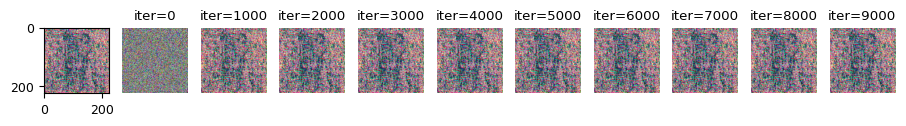

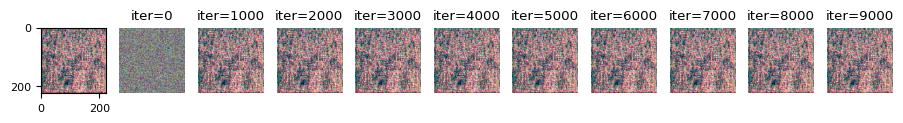

In [12]:
num_seeds=1

import traceback
try:
    # dlg_attacker_1.reset_seed(num_seeds)
    # result = dlg_attacker_1.attack(received_gradients, init_x=x_init, batch_size=batch_size)

    # gs_attacker_1.reset_seed(num_seeds)
    # result = gs_attacker_1.attack(received_gradients, init_x=x_init, batch_size=batch_size) #, labels=labels)

    # idlg_attacker_1.reset_seed(num_seeds)
    # result = idlg_attacker_1.attack(received_gradients, init_x=x_init, batch_size=batch_size)

    # cpl_attacker_1.reset_seed(num_seeds)
    # result = cpl_attacker_1.attack(received_gradients,labels=labels)

    gradinversion_attacker_1.reset_seed(num_seeds)
    result = gradinversion_attacker_1.group_attack(
        received_gradients, batch_size=batch_size
    )
    
except:
    traceback.print_exc()



In [13]:
# plt.figure(figsize=(7,8))
# multi_plot(torch.stack(result, dim=0).squeeze(),ds,dm)

In [23]:
print(len(result[0]))
print(len(result[1]))
print(len(result[2]))

2
2
2


In [25]:
result[0][1].shape

torch.Size([8, 3, 224, 224])

In [27]:
result[0][0].shape

torch.Size([8, 3, 224, 224])

In [35]:
def extracted_wanted_labels(label_shape,label_results):
        if len(label_shape) > 1: return [torch.argmax(res).item() for res in label_results]
        else : return label_results

In [36]:
result_labels = []
for i in range(len(result[1])):
    result_labels.append(extracted_wanted_labels(result[1][i].shape,result[1][i]))
result_labels

[[160, 438, 862, 403, 337, 219, 11, 700],
 [862, 337, 219, 160, 403, 700, 438, 11]]

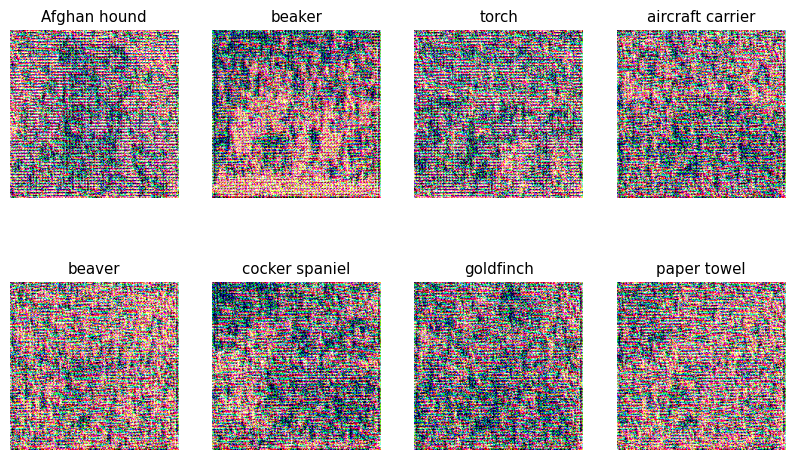

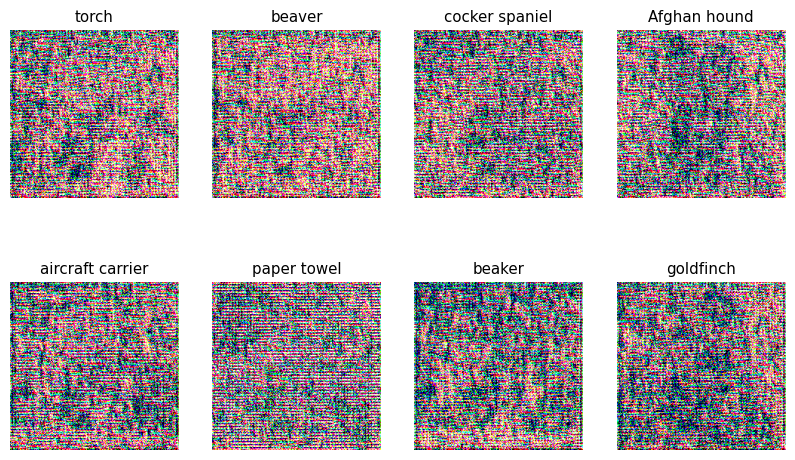

In [39]:
for i in range(len(result[0])):
    result[0][i].requires_grad=False
    multi_plot(result[0][i],ds,dm,labels=result_labels[i],classes=dataloader.dataset.classes)

In [32]:
losses = gradinversion_attacker_1.get_best_loss()
losses

[tensor(1.0171, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.0149, device='cuda:0', grad_fn=<AddBackward0>)]

In [41]:
origin_labels = labels.tolist()

for worker_id in range(group_num):
    for i,current_label in enumerate(result_labels[worker_id]):
        try:
            found = origin_labels.index(current_label)
        except:
            continue
        
        output = result[0][worker_id][i].detach().unsqueeze(0)
        matched_ground_truth = ground_truth[found].detach().unsqueeze(0)
        output.requires_grad=False
        matched_ground_truth.requires_grad=False

        test_mse = (output - matched_ground_truth).pow(2).mean()

        feat_mse = (net(output)- net(matched_ground_truth)).pow(2).mean()  
        test_psnr = psnr(output, matched_ground_truth, factor=1/ds)

        D = SSIM(channels=3)
        test_ssim = D(output.detach(), matched_ground_truth, as_loss=False).mean()

        lpips_loss = lpips.LPIPS(net='vgg', spatial=True).to(**setup)
        lpips_score = lpips_loss.forward(matched_ground_truth, output.detach()).mean()
        
        print(f"==={worker_id}===")
        print(i)
        print(test_mse.item())
        print(feat_mse.item())
        print(test_ssim.item())
        print(test_psnr)
        print(lpips_score.item())
        print(str(dataloader.dataset.classes[labels[i]][0]))
        # losses[worker_id]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
===0===
0
1.2427037954330444
1.1962967619183473e-05
0.003636997891589999
5.0769243240356445
0.8309796452522278
beaver
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
===0===
1
1.3054572343826294
5.017379862692906e-06
0.0012582596391439438
4.862973213195801
0.9482274055480957
cocker spaniel
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
===0===
2
1.1646009683609009
1.38067707666778e-05
0.0060762669891119
5.358828544616699
0.8933729529380798
torch
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /home/msyu/anaconda3/

In [18]:
origin_labels

[337, 219, 862, 403, 11, 160, 700, 438]